## Is it a cat?

In [1]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
!pip install --default-timeout=100 -Uqq fastai duckduckgo_search

## Step 1: Download images of cats and non-cats

In [3]:
from duckduckgo_search import DDGS
from fastcore.all import *

# def search_images(term, max_images=30):
#     print(f"Searching for '{term}'")
#     return L(DDGS().images((term, max_results=max_images)).itemgot('image')
def search_images(term, max_images=30):
    with DDGS(headers = {"Accept-Encoding": "gzip, deflate, br"}) as ddgs:
        results = ddgs.images(keywords=term)
        images = [next(results).get("image") for _ in range(max_images)]
        return L(images)

In [4]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('cat photos', max_images=1)
urls[0]

'https://cdn.pixabay.com/photo/2017/05/29/15/34/kitten-2354016_1280.jpg'

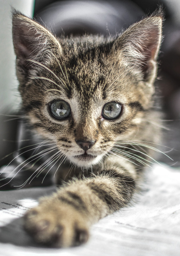

In [5]:
from fastdownload import download_url
dest = 'cat.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

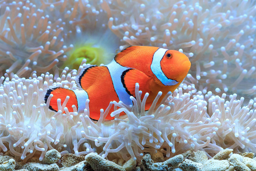

In [8]:
download_url(search_images('fish photos', max_images=1)[0], 'fish.jpg', show_progress=False)
Image.open('fish.jpg').to_thumb(256,256)

In [9]:
searches = 'cat','fish'
path = Path('cat_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

## Step 2: Train our model

In [10]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

10

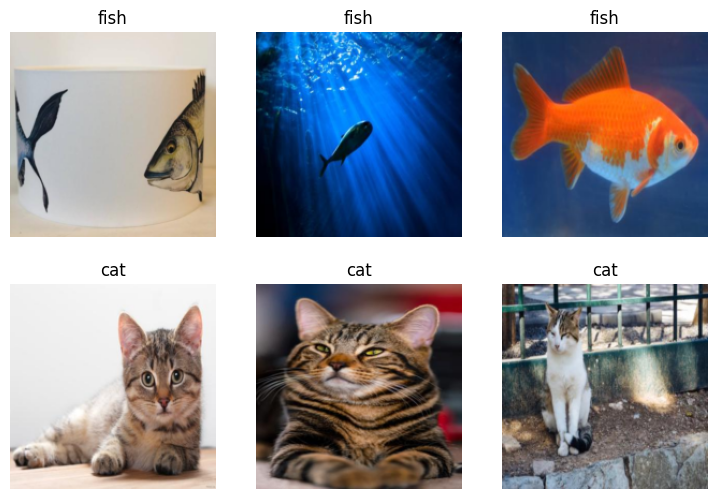

In [11]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [12]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/ninew/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:02<00:00, 19.3MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.031428,0.397201,0.161290,00:19


epoch,train_loss,valid_loss,error_rate,time
0,0.223414,0.403874,0.193548,00:05
1,0.153331,0.328369,0.129032,00:03
2,0.117706,0.171436,0.129032,00:03


## Step 3: Use our model (and build your own!)

In [14]:
is_cat,_,probs = learn.predict(PILImage.create('cat.jpg'))
print(f"This is a: {is_cat}.")
print(f"Probability it's a cat: {probs[0]:.4f}")

This is a: cat.
Probability it's a cat: 1.0000
